If on google collab, if not skip the following cell

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/TFG_Matematicas'

Mounted at /content/gdrive
/content/gdrive/MyDrive/TFG_Matematicas


## Preparation to test models

In [ ]:
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, SimpleRNN, LSTM, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import visualkeras
from keras.utils import plot_model
from utils.utils import *


In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
print("All devices: ", tf.config.list_logical_devices('TPU'))
tpu_strategy = tf.distribute.TPUStrategy(tpu)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
train_idxs = read_indexes('./utils/train.txt')
validation_idxs =  read_indexes('./utils/validation.txt')
test_idxs = read_indexes('./utils/test.txt')

In [ ]:
data_indexes = [(i+1,j+1) for i in range(5) for j in range(2000)]
parameters = load_parameter_list()
df_parameters = pd.DataFrame(parameters, columns=['cx', 'cy', 'a', 'b', 'theta', 'e1', 'e2'])
df_parameters['data_index'] = data_indexes

y_train = df_parameters[df_parameters['data_index'].isin(train_idxs)].drop('data_index', axis = 1)
y_validation = df_parameters[df_parameters['data_index'].isin(validation_idxs)].drop('data_index', axis = 1)
y_test = df_parameters[df_parameters['data_index'].isin(test_idxs)].drop('data_index', axis = 1)

In [ ]:
X_train = np.array(load_data_multithreaded(train_idxs,50))
print('train loaded')
X_validation = np.array(load_data_multithreaded(validation_idxs,50))
print('validation loaded')
X_test = np.array(load_data_multithreaded(test_idxs,50,))
print('test loaded')

train loaded
validation loaded
test loaded
Time taken: 113.855771 seconds


# Preparing metrics

In [ ]:
METRICS=[tf.keras.metrics.RootMeanSquaredError(name='rmse'),
            tf.keras.metrics.MeanAbsoluteError(name='mae'),
            tf.keras.metrics.R2Score(name='r2score')]

# Feedforward model

In [ ]:
# Define the model
feedforward = tf.keras.Sequential([
    Input(shape=(4400, 17)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

feedforward.compile(optimizer='adam', loss='mse', metrics=[METRICS])
feedforward.summary()
plot_model(feedforward, to_file='figures/feedforward_1.png', show_shapes=True, show_layer_names=False)
visualkeras.layered_view(feedforward, legend=True, to_file='figures/feedforward_2.png', spacing = 15)

In [ ]:
# Train the model
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = feedforward.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, verbose = 1)
                          #, callbacks=[early_stopping])


Epoch 1/50
133/133 [==============================] - 4s 13ms/step - loss: 1.4394 - rmse: 1.1081 - mae: 0.7185 - r2score: 0.0746 - val_loss: 1.1747 - val_rmse: 1.0838 - val_mae: 0.7026 - val_r2score: 0.1402
Epoch 2/50
133/133 [==============================] - 1s 10ms/step - loss: 1.0536 - rmse: 1.0265 - mae: 0.6667 - r2score: 0.2703 - val_loss: 1.1430 - val_rmse: 1.0691 - val_mae: 0.6938 - val_r2score: 0.2241
Epoch 3/50
133/133 [==============================] - 1s 7ms/step - loss: 0.9684 - rmse: 0.9840 - mae: 0.6294 - r2score: 0.3388 - val_loss: 0.9710 - val_rmse: 0.9854 - val_mae: 0.6052 - val_r2score: 0.3703
Epoch 4/50
133/133 [==============================] - 1s 9ms/step - loss: 0.9308 - rmse: 0.9648 - mae: 0.6121 - r2score: 0.3643 - val_loss: 1.0815 - val_rmse: 1.0400 - val_mae: 0.6690 - val_r2score: 0.2732
Epoch 5/50
133/133 [==============================] - 1s 11ms/step - loss: 0.8520 - rmse: 0.9230 - mae: 0.5761 - r2score: 0.4159 - val_loss: 1.1307 - val_rmse: 1.0633 - val_m

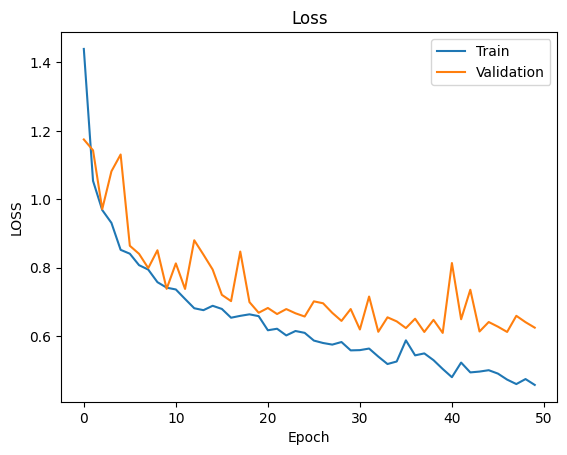

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(feedforward, X_test, y_test, random_samples = 10)

45/45 [==============================] - 0s 3ms/step - loss: 0.6172 - rmse: 0.7857 - mae: 0.4414 - r2score: 0.5823
Test mse: 0.6172470450401306
Test rmse: 0.7856507301330566
Test mae: 0.44144099950790405
Test r2score: 0.5822504162788391
1/1 [==============================] - 0s 72ms/step


Random prediction examples
Parameters:	cx	cy	a	b	theta	e1	e2
------------
real:		 1.990	4.107	1.442	0.371	0.477	1.542	0.400
prediction:	 1.547	4.271	1.307	0.516	0.406	1.664	0.404
------------
real:		 0.673	3.244	0.219	0.014	-0.058	2.608	6.740
prediction:	 1.074	3.928	1.062	-0.030	0.289	0.977	5.171
------------
real:		 -0.684	3.599	1.289	0.363	0.289	1.058	5.372
prediction:	 -0.826	3.784	1.213	0.322	0.361	0.971	5.786
------------
real:		 0.550	2.291	1.572	0.800	-0.028	3.016	6.429
prediction:	 0.798	2.338	1.483	0.941	0.205	3.098	6.083
------------
real:		 -0.360	1.772	1.716	0.847	0.666	3.115	5.051
prediction:	 -0.433	1.718	1.414	0.836	0.342	3.390	5.646
------------
real:		 -0.604	2.569	1.023	0.892	0.408

# Convolutional model

In [ ]:
cnn = tf.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(4400, 17, 1), padding='same'),
  BatchNormalization(),
  MaxPooling2D((1, 2)),

  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),#
  MaxPooling2D((1, 2)),

  Flatten(),

  Dense(1024, activation='relu'),
  Dense(512, activation='relu'),
  Dense(256, activation='relu'),
  Dense(128, activation='relu'),
  Dense(64, activation='relu'),
  Dense(7)
])

cnn.compile(optimizer='adam', loss='mse', metrics=[METRICS])
#cnn.summary()
plot_model(cnn, to_file='figures/cnn_1.png', show_shapes=True, show_layer_names=False)
visualkeras.layered_view(cnn, legend=True, to_file='figures/cnn_2.png', spacing = 15)

In [ ]:
# Train the model
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=50, verbose = 1)
                          #, callbacks=[early_stopping])

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(cnn, X_test, y_test, random_samples = 10)

# Recurrent Neural Network with simple RNN layer

In [ ]:
#with tf.device('/device:GPU:0'):
rnn = tf.keras.Sequential([
    SimpleRNN(30, input_shape=(4400, 17), return_sequences=True),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn.compile(optimizer='adam', loss='mse', metrics=METRICS)
rnn.summary()
plot_model(rnn, to_file='figures/rnn_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnn_2.png', spacing = 15)

In [ ]:
# Train the model
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=20, verbose = 1)#, callbacks=[early_stopping])

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(rnn, X_test, y_test)

#  Recurrent Neural Network Model with LSTM

In [ ]:
rnn_lstm = tf.keras.Sequential([
    LSTM(30, input_shape=(440, 17), return_sequences = True),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(7)
])

rnn_lstm.compile(optimizer='adam', loss='mse', metrics=METRICS)
rnn_lstm.summary()
plot_model(rnn, to_file='figures/rnnlstm_1.png', show_shapes=True, show_layer_names=False)
#visualkeras.layered_view(rnn, legend=True, to_file='figures/rnnlstm_2.png', spacing = 15)

In [ ]:
# Train the model
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
history = rnn_lstm.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=40, verbose = 1)#, callbacks=[early_stopping])

In [ ]:
plot_metrics(history, 'loss')

In [ ]:
model_evaluation(rnn_lstm, X_test, y_test,random_samples = 10)